# Ch.05 業務要件と処理パターン

## 5.3 季節などの周期性で売上予測（時系列分析）

「過去の目的変数の値をもとに、未来の目的変数の数値を予測する」

「周期性を前提とした予測」

- 季節などの周期性で売上予測
  - 教師あり
  - 時系列分析
  - Proshetによる時系列分析

In [1]:
# 共通事前処理

# データフレーム表示用関数
from IPython.display import display
# ライブラリーのインポート
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings("ignore")

# 表示オプション
# NumPyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)
# pandasの浮動小数点の表示精度
pd.options.display.float_format = "{:.4f}".format
# データフレームのすべての項目を表示
pd.set_option("display.max_columns", None)
# グラフのスタイルの設定
plt.style.use('seaborn')
# グラフのデフォルトフォント設定
plt.rcParams["font.size"] = 14
# グラフで日本語表示が可能なフォントの設定
plt.rcParams["font.family"] = 'IPAexGothic'
# 乱数の種pytho
RANDOM_SEED = 123

### 5.3.1 処理パターンと想定される業務利用シーン

### 5.3.2 例題のデータ説明とユースケース

- [Bike Sharing Dataset Data set](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)
- 入力変数
  - instant: インデックス
  - dteday: 日付(yy-mm-dd)
  - season: 季節 (1: 冬 2: 春 3: 夏 4:秋)
  - yr: 年 (0: 2011, 1:2012)
  - mnth: 月 (1 - 12)
  - hr: 時間 (0 - 23)
  - holiday: 祝日
  - weekday: 曜日 (0 - 6)
  - workingday: 勤務日 (1: 勤務日 0: 休日)
  - weathersit: 天気 (1: 晴れから曇り 2: 霧 3: 小雨 4: 大雨)
  - temp: 気温 (正規化済み)
  - atemp: 体感気温 (正規化済み)
  - hum: 湿度 (正規化済み)
  - windspeed: 風速 (正規化済み)
- 目的変数
  - casual: 臨時利用者数
  - registered 登録利用者数
  - cnt: 全体利用者数

### 5.3.3 モデルの概要

### 5.3.4 データ読み込みからデータ確認まで

データ読み込み

In [ ]:
# ダウンロード元URL
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/\Bike-Sharing-Dataset.zip'

# 公開データのダウンロードと解凍
!wget $url -O Bike-Sharing-Dataset.zip | tail -n 1
!unzip -o Bike-Sharing-Dataset.zip | tail -n 1

In [2]:
# day.csvをデータフレームに取り込み
# 日付を表す列はparse_datesで指定する
df = pd.read_csv('day.csv', parse_dates=[1])

In [3]:
# instant は連番で予測で不要なので削除
df = df.drop('instant', axis=1)

# 項目名の日本語化
columns = [
    '日付',  '季節',  '年', '月', '祝日', '曜日', '勤務日', '天気',
    '気温', '体感温度',  '湿度', '風速',
    '臨時ユーザー利用数', '登録ユーザー利用数', '全体ユーザー利用数'
]

# 項目名を日本語に置き換え
df.columns = columns

データ確認

In [4]:
# 先頭5行の確認
display(df.head())

# 最終5行の確認
display(df.tail())

,日付,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速,臨時ユーザー利用数,登録ユーザー利用数,全体ユーザー利用数
0,2011-01-01,1,0,1,0,6,0,2,0.3442,0.3636,0.8058,0.1604,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.3635,0.3537,0.6961,0.2485,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.1964,0.1894,0.4373,0.2483,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.2000,0.2121,0.5904,0.1603,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.2270,0.2293,0.4370,0.1869,82,1518,1600


,日付,季節,年,月,祝日,曜日,勤務日,天気,気温,体感温度,湿度,風速,臨時ユーザー利用数,登録ユーザー利用数,全体ユーザー利用数
726,2012-12-27,1,1,12,0,4,1,2,0.2542,0.2266,0.6529,0.3501,247,1867,2114
727,2012-12-28,1,1,12,0,5,1,2,0.2533,0.2550,0.5900,0.1555,644,2451,3095
728,2012-12-29,1,1,12,0,6,0,2,0.2533,0.2424,0.7529,0.1244,159,1182,1341
729,2012-12-30,1,1,12,0,0,0,1,0.2558,0.2317,0.4833,0.3508,364,1432,1796
730,2012-12-31,1,1,12,0,1,1,2,0.2158,0.2235,0.5775,0.1548,439,2290,2729


### 5.3.5 データ前処理とデータ分割

データ前処理

- Prophet用に列名を置き換える

In [5]:
# 「日付」と「登録ユーザー利用数」のみ抽出し、
# 列名を日付:ds 、登録ユーザー利用数:y に置き換えたデータフレームdf2を作る

# データフレーム全体のコピー
df2 = df.copy()

# 「日付」「登録ユーザー利用数」列の抽出
df2 = df2[['日付', '登録ユーザー利用数']]

# 列名の置き換え
df2.columns = ['ds', 'y']

# 結果確認
display(df2.head())

,ds,y
0,2011-01-01,654
1,2011-01-02,670
2,2011-01-03,1229
3,2011-01-04,1454
4,2011-01-05,1518


データ分割

- 2012年11月1日より前を訓練データ(x_train)に、後ろを検証データ(x_test)にする

In [6]:
# 分割日 mdayの設定
mday = pd.to_datetime('2012-11-1')

# 訓練用indexと検証用indexを作る
train_index = df2['ds'] < mday
test_index = df2['ds'] >= mday

# 入力データの分割
x_train = df2[train_index]
x_test = df2[test_index]

# 日付データの分割(グラフ表示用)
dates_test = df2['ds'][test_index]

### 5.3.6 アルゴリズム選択

In [11]:
# ライブラリのimport

from prophet import Prophet

# モデル選定
# 3つのseasonalityパラメータの設定が重要
# 今回のデータの場合、日単位のデータなのでdaily_seasonalityは不要
# weekly_seasonality とdaily_seasonalityは
# True / Falseの他に数値で指定することも可能 (三角関数の個数)
# seasonality_mode: additive(デフォルト) multiplicative

m1 = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

### 5.3.7 学習・予測

学習

In [12]:
# 学習
m1.fit(x_train)

08:32:21 - cmdstanpy - INFO - Chain [1] start processing
08:32:22 - cmdstanpy - INFO - Chain [1] done processing


予測

In [13]:
# 予測用データの作成
# (日付 ds だけの入ったデータフレーム)
# 61は予測したい日数 (2012-11-1 から2012-12-31)
future1 = m1.make_future_dataframe(periods=61, freq='D')

# 結果確認
display(future1.head())
display(future1.tail())

,ds
0,2011-01-01
1,2011-01-02
2,2011-01-03
3,2011-01-04
4,2011-01-05


,ds
726,2012-12-27
727,2012-12-28
728,2012-12-29
729,2012-12-30
730,2012-12-31


In [14]:
# 予測
# 結果はデータフレームで戻ってくる
fcst1 = m1.predict(future1)

### 5.3.8 評価

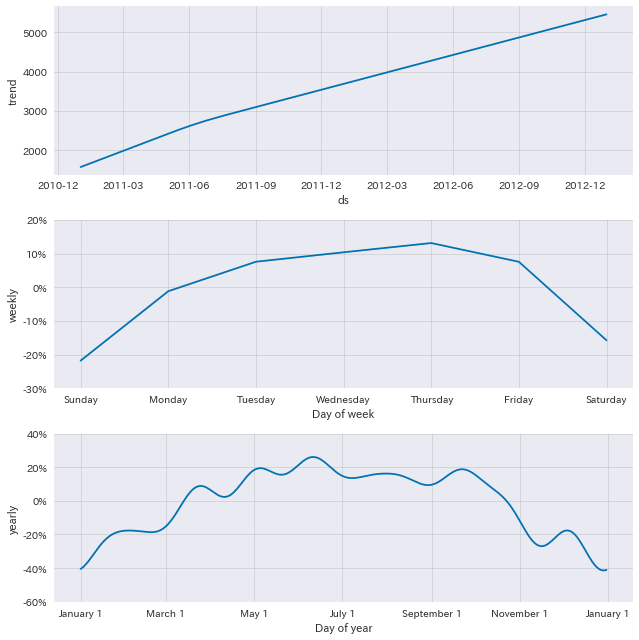

In [15]:
# 要素ごとのグラフ描画
# この段階ではトレンド、週周期、年周期
fig = m1.plot_components(fcst1)
plt.show()

訓練データ・検証データ全体のグラフ化

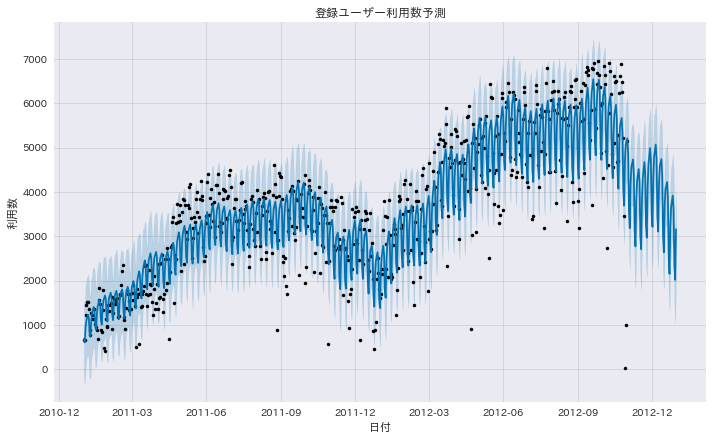

In [16]:
# 訓練データ・検証データ全体のグラフ化
fig, ax = plt.subplots(figsize=(10, 6))

# 予測結果のグラフ表示(prophetの関数)
m1.plot(fcst1, ax=ax)

# タイトル設定など
ax.set_title('登録ユーザー利用数予測')
ax.set_xlabel('日付')
ax.set_ylabel('利用数')

# グラフ表示
plt.show()

R2値の計算

In [17]:
# ypred1: fcst1から予測部分のみ抽出する

from sklearn.metrics import r2_score

ypred1 = fcst1[-61:][['yhat']].values

# ytest1: 予測期間中の正解データ
ytest1 = x_test['y'].values

# R2値の計算
score = r2_score(ytest1, ypred1)

# 結果確認
print(f'R2 score:{score:.4f}')

R2 score:0.3727


予測期間中のグラフ表示(正解データと予測結果)

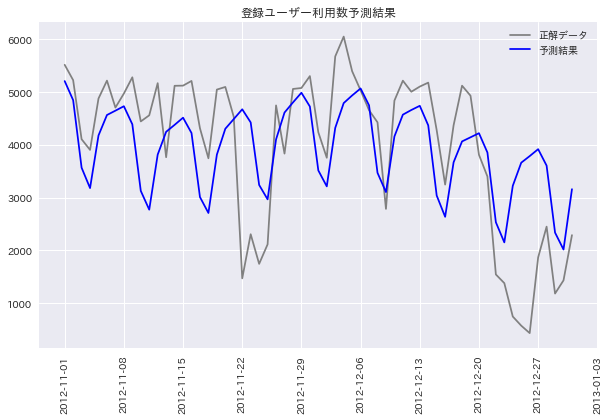

In [21]:
# 時系列グラフの描画
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 6))

# グラフ描画
ax.plot(dates_test, ytest1, label='正解データ', c='gray')
ax.plot(dates_test, ypred1, label='予測結果', c='blue')

# 日付目盛間隔
# 木曜日ごとに日付を表示
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

# 方眼表示など
# ax.grid()
ax.legend()
ax.set_title('登録ユーザー利用数予測結果')

# 画面出力
plt.show()

- チューニング方針
  - ステップ1 「休日」を特別な日として追加
  - ステップ2 回帰モデルに「天気」「気温」「風速」「湿度」を追加

### 5.3.9 チューニング（ステップ1）

- 「休日」を特別な日 (holidays)として追加

In [23]:
# 休日の抽出
df_holiday = df[df['祝日'] == 1]
holidays = df_holiday['日付'].values

# データフレーム形式に変換
df_add = pd.DataFrame(
    {'holiday': 'holi',
    'ds': holidays,
    'lower_window': 0,
    'upper_window': 0}
)

# 結果確認
print(df_add.shape)
display(df_add.head())
display(df_add.tail())

(21, 4)


,holiday,ds,lower_window,upper_window
0,holi,2011-01-17,0,0
1,holi,2011-02-21,0,0
2,holi,2011-04-15,0,0
3,holi,2011-05-30,0,0
4,holi,2011-07-04,0,0


,holiday,ds,lower_window,upper_window
16,holi,2012-09-03,0,0
17,holi,2012-10-08,0,0
18,holi,2012-11-12,0,0
19,holi,2012-11-22,0,0
20,holi,2012-12-25,0,0


In [24]:
# 休日(df_add)をモデルの入力とする

# アルゴリズム選定
# holidaysパラメータを追加してモデルm2を生成
m2 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True, 
    daily_seasonality=False,
    holidays=df_add, 
    seasonality_mode='multiplicative'
)

# 学習
m2 = m2.fit(x_train)

# 予測
fcst2 = m2.predict(future1)

08:51:58 - cmdstanpy - INFO - Chain [1] start processing
08:51:58 - cmdstanpy - INFO - Chain [1] done processing


ステップ1の評価

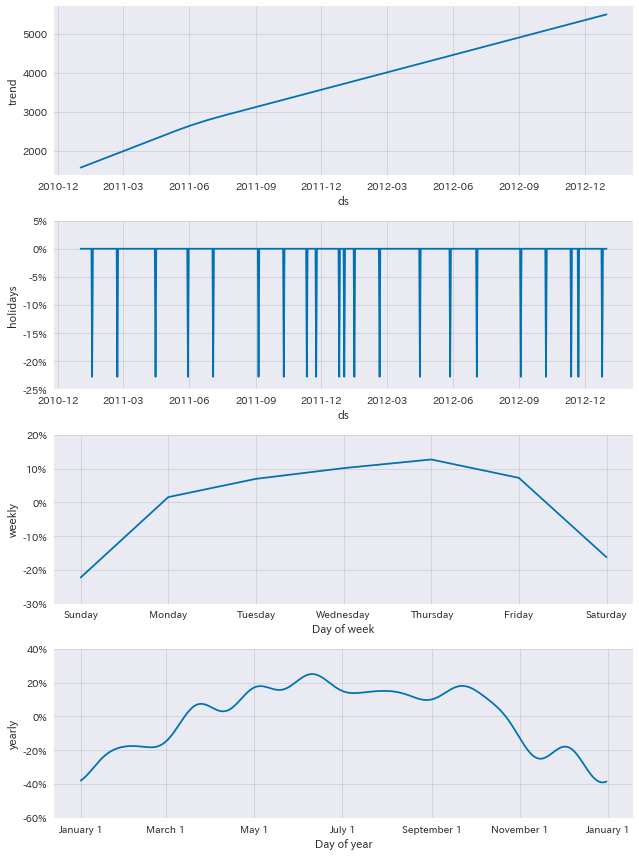

In [25]:
# 要素ごとのグラフ描画
fig = m2.plot_components(fcst2)
plt.show()

In [26]:
# R値の計算

# fcst2から予測部分のみ抽出する
ypred2 = fcst2[-61:][['yhat']].values

# R2値の計算
score2 = r2_score(ytest1, ypred2)

# 結果確認
r2_text2 = f'R2 score:{score2:.4f}'
print(r2_text2)

R2 score:0.4146


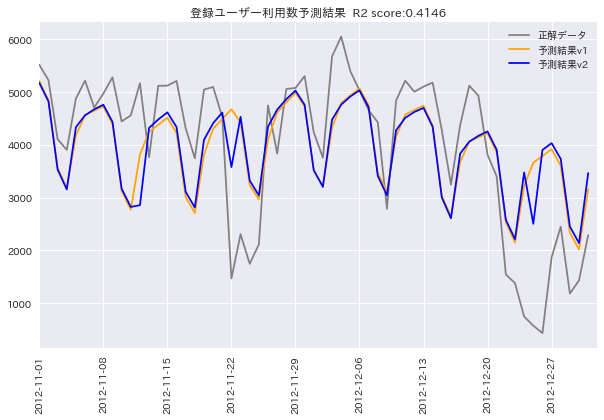

In [29]:
# 時系列グラフの描画
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 6))

# グラフ描画
ax.plot(dates_test, ytest1, label='正解データ', c='gray')
ax.plot(dates_test, ypred1, label='予測結果v1', c='orange')
ax.plot(dates_test, ypred2, label='予測結果v2', c='blue')

# 日付目盛間隔
# 木曜日ごとに日付を表示
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

# 開始日と終了日
sday = pd.to_datetime('2012-11-1')
eday = pd.to_datetime('2013-1-1')
ax.set_xlim(sday, eday)

# 方眼表示など
# ax.grid()
ax.legend()
ax.set_title('登録ユーザー利用数予測結果  ' + r2_text2)

# 画面出力
plt.show()

### 5.3.10 チューニング (ステップ2)

「天気」「気温」「風速」「湿度」を予測モデルに組み込む

In [30]:
# 学習データに「天気」「気温」「風速」「湿度」を追加
df3 = pd.concat([df2, df[['天気', '気温', '風速', '湿度']]], axis=1)

# 入力データの分割
x2_train = df3[train_index]
x2_test = df3[test_index]

# 結果確認
display(x2_train.tail())

,ds,y,天気,気温,風速,湿度
665,2012-10-27,5209,2,0.5300,0.2357,0.7200
666,2012-10-28,3461,2,0.4775,0.3980,0.6946
667,2012-10-29,20,3,0.4400,0.3582,0.8800
668,2012-10-30,1009,2,0.3182,0.2130,0.8255
669,2012-10-31,5147,2,0.3575,0.1667,0.6667


In [31]:
# アルゴリズム選定

m3 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True, 
    daily_seasonality=False,
    seasonality_mode='multiplicative', 
    holidays=df_add
)

#  add_regressor関数で、「天気」「気温」「風速」「湿度」をモデルに組み込む
m3.add_regressor('天気')
m3.add_regressor('気温')
m3.add_regressor('風速')
m3.add_regressor('湿度')

# 学習
m3.fit(x2_train)

08:59:53 - cmdstanpy - INFO - Chain [1] start processing
08:59:53 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
# 予測用の入力データを作る
future3 = df3[['ds', '天気', '気温', '風速', '湿度']]

# 予測
fcst3 = m3.predict(future3)

ステップ2の評価

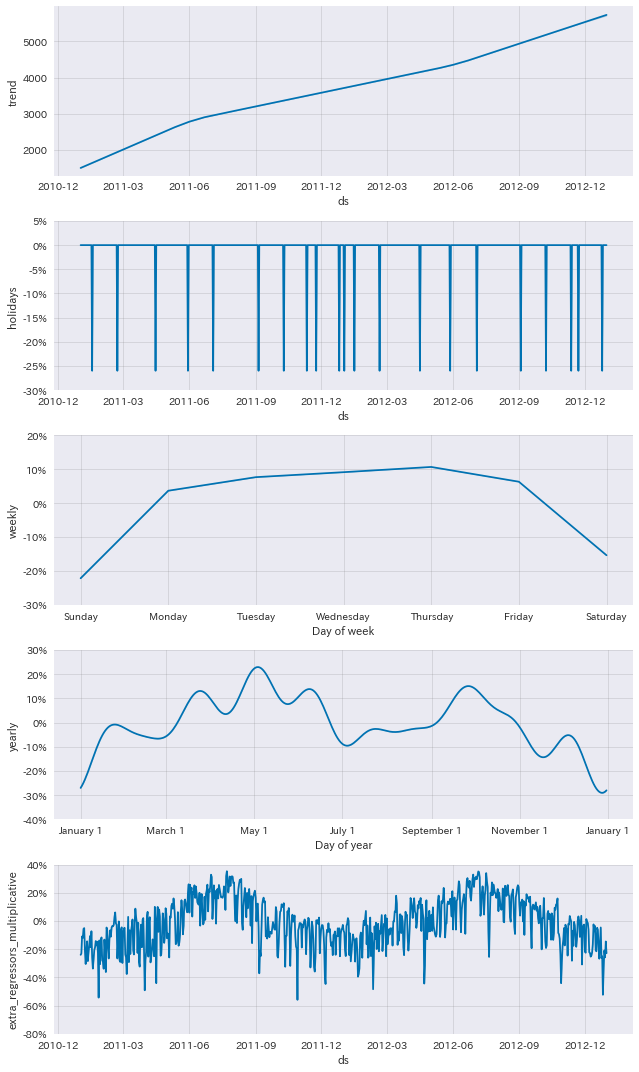

In [33]:
# 要素ごとのグラフ描画
fig = m3.plot_components(fcst3)
plt.show()

In [34]:
# R値の計算

# fcstから予測部分のみ抽出する
ypred3 = fcst3[-61:][['yhat']].values
score3 = r2_score(ytest1, ypred3)

# 結果確認
r2_text3 = f'R2 score:{score3:.4f}'
print(r2_text3)

R2 score:0.6197


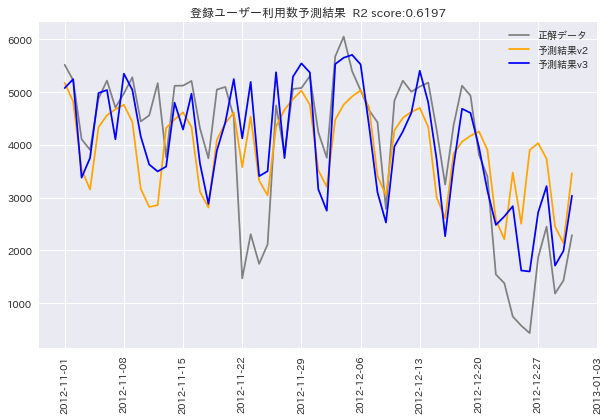

In [36]:
# 時系列グラフの描画
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 6))

# グラフ描画
ax.plot(dates_test, ytest1, label='正解データ', c='gray')
ax.plot(dates_test, ypred2, label='予測結果v2', c='orange')
ax.plot(dates_test, ypred3, label='予測結果v3', c='blue')

# 日付目盛間隔
# 木曜日ごとに日付を表示
weeks = mdates.WeekdayLocator(byweekday=mdates.TH)
ax.xaxis.set_major_locator(weeks)

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

# 方眼表示など
# ax.grid()
ax.legend()
ax.set_title('登録ユーザー利用数予測結果  ' + r2_text3)

# 画面出力
plt.show()

## コラム 「アイスクリーム購買予測」で時系列分析

- オリジナルデータ
  - アイスクリーム調査報告書
  - https://www.icecream.or.jp/biz/data/expenditures.html

In [37]:
# データ読み込み

url2 = 'https://github.com/makaishi2/sample-data/blob/master/data/ice-sales.xlsx?raw=true'

df = pd.read_excel(url2, sheet_name=0)

In [38]:
# データ確認
display(df.head())
display(df.tail())

,年月,支出
0,2015-01-01,401
1,2015-02-01,345
2,2015-03-01,480
3,2015-04-01,590
4,2015-05-01,928


,年月,支出
55,2019-08-01,1513
56,2019-09-01,996
57,2019-10-01,724
58,2019-11-01,531
59,2019-12-01,584


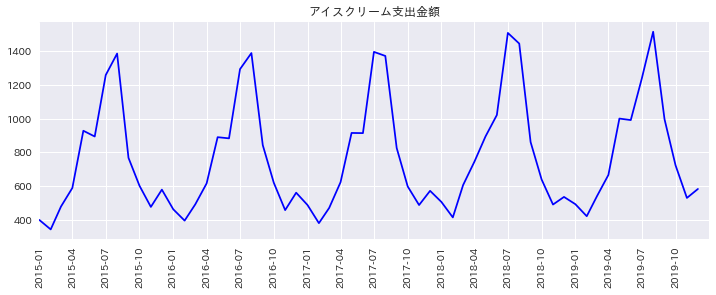

In [40]:
# 時系列グラフの描画 (アイスクリーム支出金額)
fig, ax = plt.subplots(figsize=(12, 4))

# グラフ描画
ax.plot(df['年月'], df['支出'], c='b')

# 3か月区切りの目盛にする
month3 = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(month3)

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

# 開始日と終了日
sday = pd.to_datetime('2015-1-1')
eday = pd.to_datetime('2019-12-31')
ax.set_xlim(sday, eday)

# 方眼表示など
# ax.grid()
ax.set_title('アイスクリーム支出金額')

# 画面出力
plt.show()

In [41]:
# データ前処理
# データ形式をProphet用に合わせる
x = df.copy()
x.columns = ['ds', 'y']
display(x.head())

,ds,y
0,2015-01-01,401
1,2015-02-01,345
2,2015-03-01,480
3,2015-04-01,590
4,2015-05-01,928


In [42]:
# データ分割
# 2019年1月を基準に訓練データと検証データを分割
# 分割日 mdayの設定
mday = pd.to_datetime('2019-1-1')

# 訓練用indexと検証用indexを作る
train_index = x['ds'] < mday
test_index = x['ds'] >= mday

# 入力データの分割
x_train = x[train_index]
x_test = x[test_index]

#日付列もグラフ描画のために分割
dates_train = x['ds'][train_index]
dates_test = x['ds'][test_index]

In [43]:
# アルゴリズムの選択
# ライブラリのimport
from prophet import Prophet

m = Prophet(
    yearly_seasonality=5, 
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

In [44]:
# 学習
m = m.fit(x_train)

09:11:37 - cmdstanpy - INFO - Chain [1] start processing
09:11:37 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
# 予測
future = x[['ds']]
fcst = m.predict(future)

In [46]:
# 評価

from sklearn.metrics import r2_score

# fcstから予測部分のみ抽出する
ypred = fcst[-12:]['yhat'].values

# 正解データのリスト
ytest = x_test['y'].values

# R値の計算
score = r2_score(ytest, ypred)
score_text = f'R2 score:{score:.4f}'
print(score_text)

R2 score:0.9415


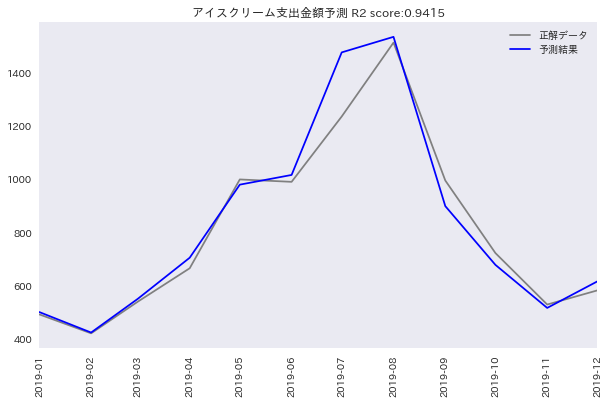

In [47]:
# 時系列グラフの描画 (アイスクリーム支出金額)
fig, ax = plt.subplots(figsize=(10, 6))

# グラフ描画
ax.plot(dates_test, ytest, label='正解データ', c='gray')
ax.plot(dates_test, ypred, label='予測結果', c='blue')

# 1か月区切りの目盛にする
month = mdates.MonthLocator()
ax.xaxis.set_major_locator(month)

# 日付表記を90度回転
ax.tick_params(axis='x', rotation=90)

# 開始日と終了日
sday = pd.to_datetime('2019-1-1')
eday = pd.to_datetime('2019-12-1')
ax.set_xlim(sday, eday)

# 方眼表示など
ax.grid()
ax.legend()
ax.set_title('アイスクリーム支出金額予測 ' + score_text)

# 画面出力
plt.show()